<a href="https://colab.research.google.com/github/Jdzubina/Python---Data-and-AI/blob/main/Convolutional%20Neural%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Convolutional Neural Networks**

Convolutional Neural Networks (CNNs) are a type of neural network particularly good at processing images. They work by using special layers called convolutional layers that automatically detect important features in images, like edges, textures, and shapes. These layers scan the image with small filters and create feature maps that highlight these important parts. CNNs are widely used for tasks such as image recognition, object detection, and facial recognition because they can handle the complex structure of images very efficiently. They are also used in applications like self-driving cars, where they help recognize and understand surroundings.

**Convolutional Neural Networks - LeNet to recognize handwritten digits - Code Sample**

In [ ]:
# Import Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten

class my_LeNet:
    def __init__(self, d, n, mu = 0, sigma = 0.1, lr = 0.001):
        self.mu = mu
        self.sigma = sigma
        self.n = n
        self.x = tf.placeholder(tf.float32, (None, d, d, 1))  # place holder for input image dimension 28 x 28
        self.y = tf.placeholder(tf.int32, (None,n))
        self.keep_prob = tf.placeholder(tf.float32) # probability to keep units


        self.logits = self.model(self.x)

        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=self.y, logits=self.logits)
        self.loss = tf.reduce_mean(cross_entropy)
        optimizer = tf.train.AdamOptimizer(learning_rate = lr)
        self.train = optimizer.minimize(self.loss)
        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)
        self.saver = tf.train.Saver()



    def model(self,x):
        # Build Architecture
        keep_prob = 0.7
        # Layer 1: Convolutional. Filter 5x5 num_filters = 6 Input_depth =1
        conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = self.mu, stddev = self.sigma))
        conv1_b = tf.Variable(tf.zeros(6))
        conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
        conv1 = tf.nn.relu(conv1)

        # Max Pool 1
        self.conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')


        # Layer 2: Convolutional. Filter 5x5 num_filters = 16  Input_depth =6
        conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = self.mu, stddev = self.sigma))
        conv2_b = tf.Variable(tf.zeros(16))
        conv2   = tf.nn.conv2d(self.conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
        conv2 = tf.nn.relu(conv2)

        # Max Pool 2.
        self.conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

        # Flatten.
        fc0 = Flatten()(self.conv2)
        print("x shape:",fc0.get_shape())

        # Layer 3: Fully Connected. Input = fc0.get_shape[-1]. Output = 120.
        fc1_W = tf.Variable(tf.truncated_normal(shape=(256, 120), mean = self.mu, stddev = self.sigma))
        fc1_b = tf.Variable(tf.zeros(120))
        fc1   = tf.matmul(fc0, fc1_W) + fc1_b
        fc1    = tf.nn.relu(fc1)

        # Dropout
        x = tf.nn.dropout(fc1, keep_prob)

        # Layer 4: Fully Connected. Input = 120. Output = 84.
        fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = self.mu, stddev = self.sigma))
        fc2_b  = tf.Variable(tf.zeros(84))
        fc2    = tf.matmul(x, fc2_W) + fc2_b
        fc2    = tf.nn.relu(fc2)

        # Dropout
        x = tf.nn.dropout(fc2, keep_prob)

        # Layer 6: Fully Connected. Input = 120. Output = n_classes.
        fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, self.n), mean = self.mu, stddev = self.sigma))
        fc3_b  = tf.Variable(tf.zeros(self.n))
        logits = tf.matmul(x, fc3_W) + fc3_b
        #logits = tf.nn.softmax(logits)
        return logits

    def fit(self,X,Y,X_val,Y_val,epochs=10, batch_size=100):
        X_train, y_train = X, Y
        num_examples = len(X_train)
        l = []
        val_l = []
        max_val = 0
        for i in range(epochs):
            total = 0
            for offset in range(0, num_examples, batch_size):  # Learn Batch wise
                end = offset + batch_size
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                _, loss = self.sess.run([self.train,self.loss], feed_dict={self.x: batch_x, self.y: batch_y})
                total += loss
            l.append(total/num_examples)
            accuracy_val = self.sess.run(self.accuracy, feed_dict={self.x: X_val, self.y: Y_val})
            accuracy = self.sess.run(self.accuracy, feed_dict={self.x: X, self.y: Y})
            loss_val = self.sess.run(self.loss, feed_dict={self.x:X_val,self.y:Y_val})
            val_l.append(loss_val)
            print("EPOCH {}/{} loss is {:.3f} training_accuracy {:.3f} and validation accuracy is {:.3f}".\
                  format(i+1,epochs,total/num_examples, accuracy, accuracy_val))
            if accuracy_val > max_val:
                save_path = self.saver.save(self.sess, "/tmp/lenet1.ckpt")
                print("Model saved in path: %s" % save_path)
                max_val = accuracy_val

        self.saver.restore(self.sess, "/tmp/lenet1.ckpt")
        print("Restored model with highest validation accuracy")
        accuracy_val = self.sess.run(self.accuracy, feed_dict={self.x: X_val, self.y: Y_val})
        accuracy = self.sess.run(self.accuracy, feed_dict={self.x: X, self.y: Y})
        return l,val_l, accuracy, accuracy_val

    def predict(self, X):
        return self.sess.run(self.logits,feed_dict={self.x:X})

In [ ]:
import pandas as pd
import numpy as np

def load_data():
    # Read the data and create train, validation, and test dataset
    data = pd.read_csv('train.csv')
    train = data.sample(frac=0.8, random_state=255)   # This ensures always 80% of data is training and rest Validation unlike using np.random
    val = data.drop(train.index)
    test = pd.read_csv('test.csv')
    return train, val, test

def create_data(df):
    labels = df.loc[:]['label']
    y_one_hot = pd.get_dummies(labels).astype(np.uint8)
    y = y_one_hot.values # One Hot encode the labels
    x = df.iloc[:,1:].values
    x = x.astype(float)  # Changed from np.float to float
    # Normalize data
    x = np.multiply(x, 1.0 / 255.0)
    x = x.reshape(-1, 28, 28, 1) # return each images as 28 x 28 x 1
    return x, y

train, val, test = load_data()

# Check the shape of the train, validation, and test data
print("Train shape:", train.shape)
print("Validation shape:", val.shape)
print("Test shape:", test.shape)

X_train, y_train = create_data(train)
X_val, y_val = create_data(val)

# Check the shape of the test data before reshaping
print("X_test shape before reshaping:", test.shape)

X_test = (test.iloc[:, 1:].values).astype(float)  # Changed from np.float to float
X_test = np.multiply(X_test, 1.0 / 255.0)
print("X_test shape before final reshaping:", X_test.shape)

# Reshape test data
X_test = X_test.reshape(-1, 28, 28, 1)  # return each image as 28 x 28 x 1

# Check the final shape of the test data
print("X_test shape after reshaping:", X_test.shape)

Train shape: (48000, 785)
Validation shape: (12000, 785)
Test shape: (10000, 785)
X_test shape before reshaping: (10000, 785)
X_test shape before final reshaping: (10000, 784)
X_test shape after reshaping: (10000, 28, 28, 1)


In [ ]:
def load_data():
    # Read the data and create train, validation and test dataset
    data = pd.read_csv('train.csv')
    train = data.sample(frac=0.8, random_state=255)   # This ensures always 80% of data is training and rest Validation  unlike using np.random
    val = data.drop(train.index)
    test = pd.read_csv('test.csv')
    return train, val, test

def create_data(df):
    labels = df.loc[:]['label']
    y_one_hot = pd.get_dummies(labels).astype(np.uint8)
    y = y_one_hot.values # One Hot encode the labels
    x = df.iloc[:,1:].values
    x = x.astype(float) # Use float instead of np.float
    # Normalize data
    x = np.multiply(x, 1.0 / 255.0)
    x = x.reshape(-1, 28, 28, 1) # return each images as 28 x 28 x 1
    return x,y

train, val, test = load_data()
X_train, y_train = create_data(train)
X_val, y_val = create_data(val)

# Extract features and labels from the test set
X_test = test.iloc[:, 1:].values.astype(float)
y_test_labels = test.iloc[:, 0].values  # Extract labels for the test set

# Normalize test data
X_test = np.multiply(X_test, 1.0 / 255.0)

# Reshape test data to the correct dimensions (28 x 28 x 1)
X_test = X_test.reshape(-1, 28, 28, 1) # return each image as 28 x 28 x 1

# One-hot encode the test labels
# Convert y_test_labels.max() to integer explicitly
y_test = np.zeros((y_test_labels.size, int(y_test_labels.max())+1))
y_test[np.arange(y_test_labels.size), y_test_labels.astype(int)] = 1 # Also convert y_test_labels to int for indexing

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (10000, 28, 28, 1)
y_test shape: (10000, 1)


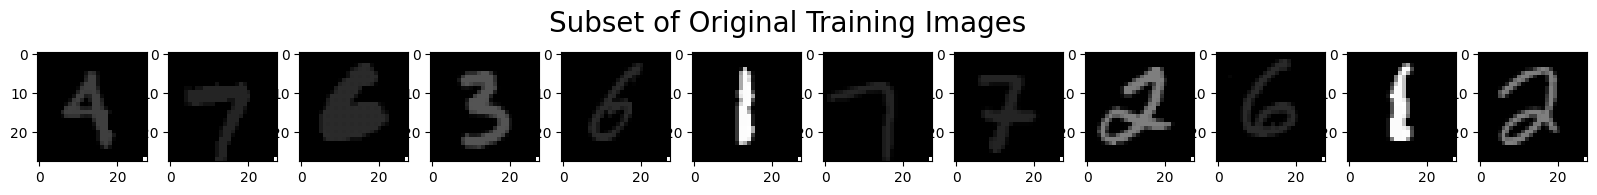

In [ ]:
# take subset of training data
x_train_subset = X_train[:12]


# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i].reshape(28,28), cmap='gray')
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

In [ ]:
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_val)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an handwritten digits?
image_shape = X_train.shape[1:-1]

# How many unique classes/labels there are in the dataset.
n_classes = y_train.shape[-1]

print("Number of training examples =", n_train)
print("Number of Validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 48000
Number of Validation examples = 12000
Number of testing examples = 10000
Image data shape = (28, 28)
Number of classes = 10


In [ ]:
# Define the data values
d = image_shape[0]
n = n_classes
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train,y_train)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input # import keras.layers
from tensorflow.keras.models import Model # import keras.models

class my_LeNet:
    def __init__(self, d, n, mu=0, sigma=0.1, lr=0.001):
        self.mu = mu
        self.sigma = sigma
        self.n = n
        self.lr = lr
        self.model = self.build_model(d, n)
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                           loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                           metrics=['accuracy'])

    def build_model(self, d, n):
        inputs = Input(shape=(d, d, 1))

        # Layer 1: Convolutional. Filter 5x5 num_filters = 6 Input_depth =1
        x = Conv2D(6, (5, 5), activation='relu', padding='valid')(inputs)
        # Max Pool 1
        x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid')(x)

        # Layer 2: Convolutional. Filter 5x5 num_filters = 16  Input_depth =6
        x = Conv2D(16, (5, 5), activation='relu', padding='valid')(x)
        # Max Pool 2.
        x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid')(x)

        # Flatten.
        x = Flatten()(x)

        # Layer 3: Fully Connected. Input = Flattened output. Output = 120.
        x = Dense(120, activation='relu')(x)
        # Dropout
        x = Dropout(0.3)(x)

        # Layer 4: Fully Connected. Input = 120. Output = 84.
        x = Dense(84, activation='relu')(x)
        # Dropout
        x = Dropout(0.3)(x)

        # Layer 5: Fully Connected. Input = 84. Output = n_classes.
        outputs = Dense(n)(x)

        model = Model(inputs=inputs, outputs=outputs)
        return model

    def fit(self, X, Y, X_val, Y_val, epochs=10, batch_size=100):
        history = self.model.fit(X, Y, epochs=epochs, batch_size=batch_size,
                                 validation_data=(X_val, Y_val))
        return history

    def predict(self, X):
        return self.model.predict(X)

    def save(self, path):
        self.model.save(path)

    def load(self, path):
        self.model = tf.keras.models.load_model(path)

# Define the input dimensions and number of classes
d = 28  # Image size 28x28
n = 10  # Number of classes

# Create the Model
my_model = my_LeNet(d, n)

# Train the Model
history = my_model.fit(X_train, y_train, X_val, y_val, epochs=10, batch_size=100)

Epoch 1/10
480/480 [==============================] - 22s 44ms/step - loss: 1.3649 - accuracy: 0.5175 - val_loss: 0.5187 - val_accuracy: 0.8313
Epoch 2/10
480/480 [==============================] - 26s 53ms/step - loss: 0.4897 - accuracy: 0.8449 - val_loss: 0.2935 - val_accuracy: 0.9124
Epoch 3/10
480/480 [==============================] - 24s 50ms/step - loss: 0.3382 - accuracy: 0.8970 - val_loss: 0.2250 - val_accuracy: 0.9304
Epoch 4/10
480/480 [==============================] - 22s 46ms/step - loss: 0.2717 - accuracy: 0.9172 - val_loss: 0.1873 - val_accuracy: 0.9420
Epoch 5/10
480/480 [==============================] - 22s 46ms/step - loss: 0.2301 - accuracy: 0.9305 - val_loss: 0.1659 - val_accuracy: 0.9486
Epoch 6/10
480/480 [==============================] - 23s 48ms/step - loss: 0.2048 - accuracy: 0.9391 - val_loss: 0.1564 - val_accuracy: 0.9507
Epoch 7/10
480/480 [==============================] - 22s 46ms/step - loss: 0.1853 - accuracy: 0.9442 - val_loss: 0.1376 - val_accuracy:

Epoch 1/10
480/480 [==============================] - 36s 75ms/step - loss: 0.1387 - accuracy: 0.9581 - val_loss: 0.1067 - val_accuracy: 0.9663
Epoch 2/10
480/480 [==============================] - 22s 47ms/step - loss: 0.1322 - accuracy: 0.9597 - val_loss: 0.1024 - val_accuracy: 0.9688
Epoch 3/10
480/480 [==============================] - 23s 48ms/step - loss: 0.1249 - accuracy: 0.9630 - val_loss: 0.0981 - val_accuracy: 0.9693
Epoch 4/10
480/480 [==============================] - 23s 48ms/step - loss: 0.1187 - accuracy: 0.9639 - val_loss: 0.0955 - val_accuracy: 0.9699
Epoch 5/10
480/480 [==============================] - 24s 51ms/step - loss: 0.1119 - accuracy: 0.9660 - val_loss: 0.0902 - val_accuracy: 0.9718
Epoch 6/10
480/480 [==============================] - 32s 67ms/step - loss: 0.1091 - accuracy: 0.9666 - val_loss: 0.0889 - val_accuracy: 0.9733
Epoch 7/10
480/480 [==============================] - 26s 54ms/step - loss: 0.1052 - accuracy: 0.9684 - val_loss: 0.0853 - val_accuracy:

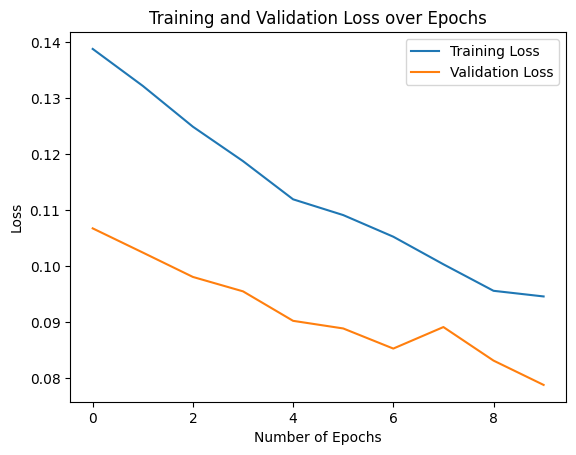

In [ ]:
import matplotlib.pyplot as plt


history = my_model.fit(X_train, y_train, X_val, y_val, epochs=10, batch_size=100)

# Extract the loss and validation loss from the history object
loss = history.history['loss'] # Updated to access loss from history object in TensorFlow 2.x
val_loss = history.history['val_loss'] # Updated to access validation loss from history object in TensorFlow 2.x

# Plotting the training and validation loss
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.show()

In [ ]:
# Extract the accuracy and validation accuracy from the history object
accuracy = history.history['accuracy']  # Updated to access accuracy from history object in TensorFlow 2.x
val_accuracy = history.history['val_accuracy']  # Updated to access validation accuracy from history object in TensorFlow 2.x

# Calculate and report the accuracy on the training and validation set.
# Using the last epoch's accuracy
train_acc = accuracy[-1]
val_acc = val_accuracy[-1]

print("Accuracy on training dataset is {:.3f}% and on Validation dataset is {:.3f}%".
      format(train_acc * 100, val_acc * 100))

Accuracy on training dataset is 97.060% and on Validation dataset is 97.525%


**Use case examples**

Smartphones like the iPhone use Convolutional Neural Networks to analyze and recognize facial features for unlocking the device. The Convolutional Neural Networks processes the image captured by the front camera, extracting unique features of the user's face and then matches these features to the stored facial data.

**My experience using this tool**

Building a convuluted neural network using the LeNet architecture was challenging due to Google Collab no longer supporting from TensorFlow 1.x and changing to to 2.x. The primary issue was the deprecation of tf.placeholder, leading to several AttributeErrors. I initially used tf.compat.v1 to enable compatibility mode but ultimately changed back to TensorFlow 2.x practices using tf.keras. I became stuck on the "# Create the Model my_model = my_LeNet(d, n)" section of the code because I got an error saying  module 'tensorflow' has no attribute 'placeholder'

Another major change involved modifying the import statements to be compatible with TensorFlow 2.x. Instead of using the deprecated tensorflow.contrib module, I updated the code to use the Keras API built into TensorFlow. I changed the import statement for flattening layers to:

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten

This resolved issues related to flattening layers in the network.

While plotting the training and validation loss, I encountered an error because the variable loss was not defined. To resolve this, I updated the code to access the loss and validation loss from the history object returned by the fit method in TensorFlow 2.x:

In [ ]:
loss = history.history['loss']  # Updated to access loss from history object in TensorFlow 2.x
val_loss = history.history['val_loss']  # Updated to access validation loss from history object in TensorFlow 2.x

This allowed me to plot the training and validation loss correctly.

I also had to update the import statements for the layers and model definitions to use the Keras API:

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input  # import keras.layers
from tensorflow.keras.models import Model  # import keras.mode

I ran into a deprecation issue with the use of np.float. TensorFlow 2.x no longer supports np.float, and using it resulted in an AttributeError. I updated the code to use the built-in float type instead

In [ ]:
x = x.astype(float)  # Use float instead of np.float

This change ensured that the data type conversion was compatible with the updated TensorFlow version.

Finally I updated the code to access accuracy from the history object in TensorFlow 2.x:

In [ ]:
accuracy = history.history['accuracy']  # Updated to access accuracy from history object in TensorFlow 2.x

and to access validation accuracy from the history object in TensorFlow 2.x:




In [ ]:
val_accuracy = history.history['val_accuracy']  # Updated to access validation accuracy from history object in TensorFlow 2.x

With these changes, I was able to successfully build and train the LeNet architecture using TensorFlow 2.x. The process taught me a lot about adapting older code to newer frameworks and the importance of keeping up-to-date with library changes.

**Teachable Machine Model training**

Teachable Machine is a web-based tool developed by Google that allows users to create machine learning models without needing to write any code. It provides an interface to train models using images, sounds, and poses. Users can then export these models for use in various applications, including websites, apps, and physical devices.

Teachable Machine Model [Link](https://teachablemachine.withgoogle.com/models/7PwjAs8NW/)

I explored using Teachable Machine and created a model that categorizes and identifies between clapping and whistling sounds. The tool was incredibly user-friendly and easy to understand, making it fairly simple to get get a feel for the basics of machine learning without writing any code. while training my clap/whistle model, I began to think about potential applications for my wine-making IoT device.

The ease of use and immediate feedback from Teachable Machine got me thinking about various classifications within the wine-making process, such as identifying different fermentation stages through images of the wine barrel or sound, monitoring weather conditions, or even distinguishing between various types of grape ripeness. It sparked new ideas on how machine learning could enhance the efficiency and accuracy of my IoT solutions in winemaking. I wonder if there is a way to create a model, export it and use it in Google collabs.